In [32]:
%matplotlib inline
import pycisTopic
pycisTopic.__version__

'1.0.1.dev8+gcb5d62f'

## 0. Set paths

In [1]:
# Variables
## Outdir
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
## Temp
tmpDir = '/scratch/leuven/313/vsc31305/'
## Path to fragments
fragments_dict = {'DPLC': '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/atac_fragments/fragments.tsv'}

## 1. QC

In [27]:
# Get TSS annotations
import pybiomart as pbm
# For mouse (mm39)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For mouse (mm10)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human (hg38)
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly (dm6)
# dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].astype('str')
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

/local_scratch/tmp-vsc31305/ipykernel_14318/2601143857.py:13: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
/local_scratch/tmp-vsc31305/ipykernel_14318/2601143857.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


In [28]:
from pycisTopic.qc import *
path_to_regions = {'DPLC':'/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/MACS_ATAC/iterative/peak_filtering_norm/combined_summits_final.bed'}
metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmpDir + 'ray_spill')

2021-12-21 13:16:24,424	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265


(compute_qc_stats_ray pid=21352) 2021-12-21 13:16:28,015 cisTopic     INFO     Reading DPLC
(compute_qc_stats_ray pid=21352) 2021-12-21 13:17:12,866 cisTopic     INFO     Computing barcode rank plot for DPLC
(compute_qc_stats_ray pid=21352) 2021-12-21 13:17:12,866 cisTopic     INFO     Counting fragments
(compute_qc_stats_ray pid=21352) 2021-12-21 13:17:15,155 cisTopic     INFO     Marking barcodes with more than 100
(compute_qc_stats_ray pid=21352) 2021-12-21 13:17:15,156 cisTopic     INFO     Returning plot data
(compute_qc_stats_ray pid=21352) 2021-12-21 13:17:15,157 cisTopic     INFO     Returning valid barcodes
(compute_qc_stats_ray pid=21352) 2021-12-21 13:17:18,934 cisTopic     INFO     Computing duplicate rate plot for DPLC
(compute_qc_stats_ray pid=21352) 2021-12-21 13:17:21,672 cisTopic     INFO     Return plot data
(compute_qc_stats_ray pid=21352) 2021-12-21 13:17:21,748 cisTopic     INFO     Computing insert size distribution for DPLC
(compute_qc_stats_ray pid=21352) 2021-1

In [29]:
os.makedirs(outDir+'quality_control')
import pickle 
with open(outDir + 'quality_control/metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc, f)

In [30]:
import pickle 
with open(outDir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


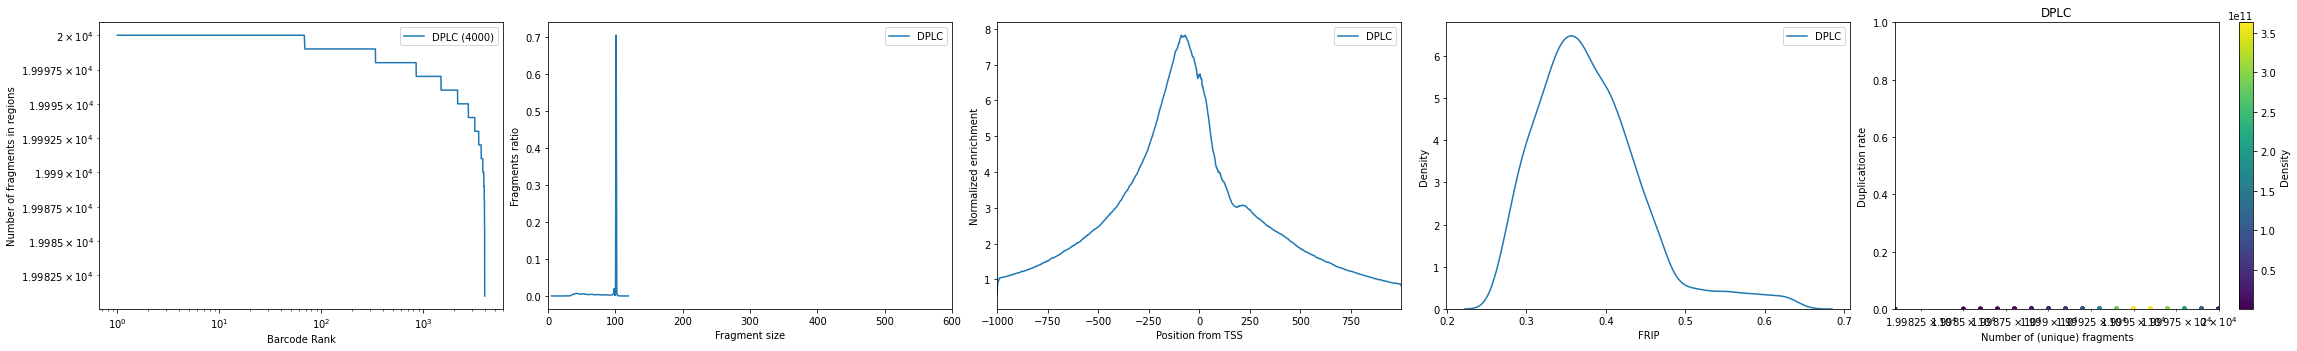

In [33]:
from pycisTopic.qc import *
plot_sample_metrics(profile_data_dict,
           insert_size_distriubtion_xlim=[0,600],
           ncol=5,
           plot=True,
           save= outDir + 'quality_control/sample_metrics.pdf')

In [34]:
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['DPLC'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=3.5,
                                       max_x=None,
                                       min_y=0.2,
                                       max_y=None,
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False,
                                       save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['DPLC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=4,
                                      max_y=None,
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False,
                                      save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG.pdf')
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['DPLC'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=3.5,
                                      max_x=None,
                                      min_y=None,
                                      max_y=None,
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distribut

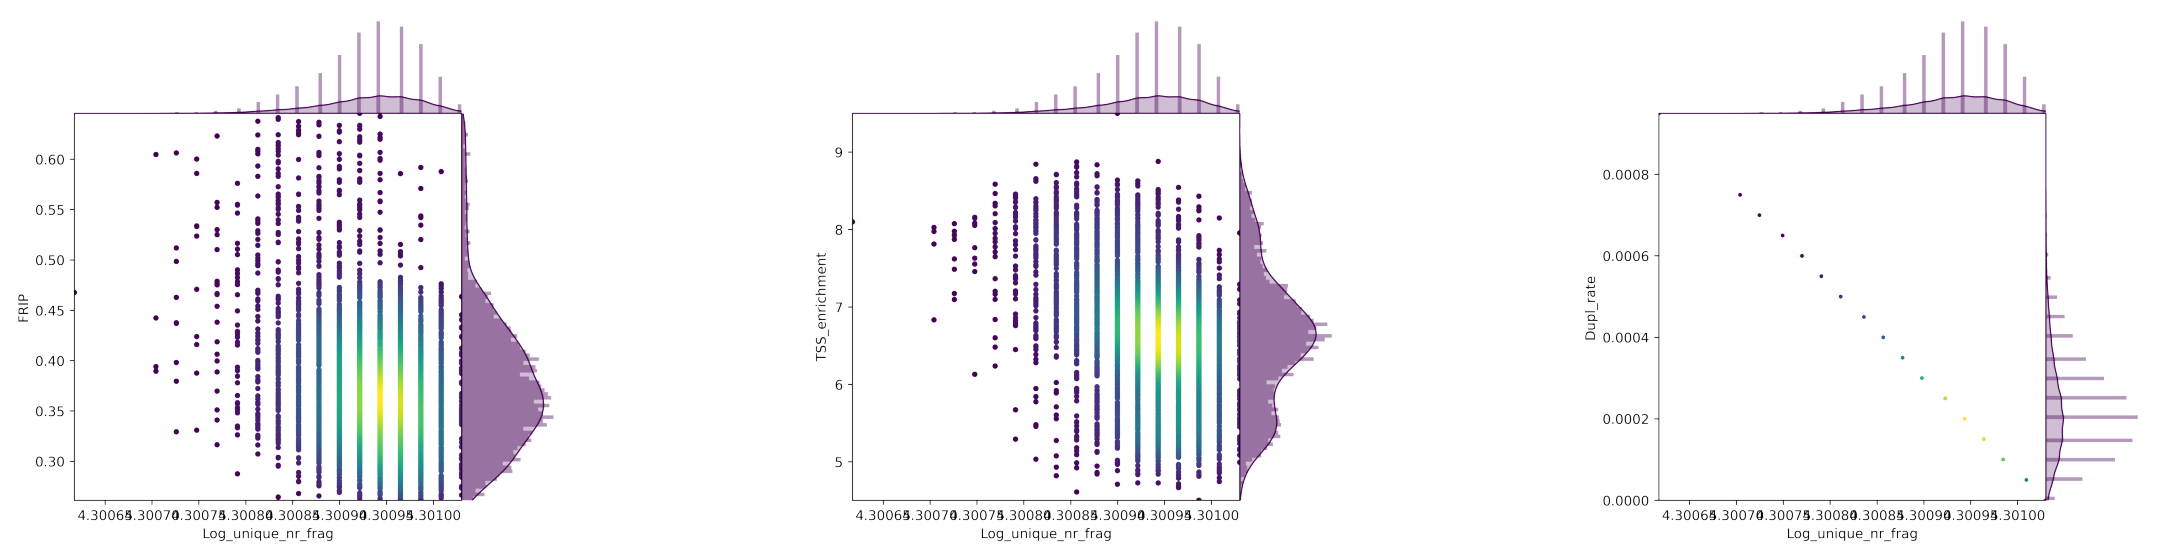

In [35]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(40,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

## 2. Create cisTopic object

In [10]:
# Path to regions
path_to_regions = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/MACS_ATAC/iterative/peak_filtering_norm/screen_overlap_combined_summits.bed'
# Blacklist
path_to_blacklist = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=None,
                                               n_cpu=1,
                                               project=key) for key in fragments_dict.keys()]

2022-01-17 17:44:32,448 cisTopic     INFO     Reading data for DPLC
2022-01-17 17:45:16,889 cisTopic     INFO     metrics provided!
2022-01-17 17:45:20,906 cisTopic     INFO     Counting fragments in regions
2022-01-17 17:46:00,569 cisTopic     INFO     Creating fragment matrix
2022-01-17 17:46:13,392 cisTopic     INFO     Data is too big, making partitions. This is a reported error in Pandas versions > 0.21 (https://github.com/pandas-dev/pandas/issues/26314)
2022-01-17 17:46:39,948 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-01-17 17:46:45,840 cisTopic     INFO     Removing blacklisted regions
2022-01-17 17:46:49,343 cisTopic     INFO     Creating CistopicObject
2022-01-17 17:46:51,175 cisTopic     INFO     Done!
2022-01-17 17:47:08,677 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-01-17 17:47:16,725 cisTopic     INFO     Removing blacklisted regions
2022-01-17 17:47:20,141 cisTopic     INFO     Creating CistopicObject
2022-01-17 17:

In [11]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 4000 × 783130


In [12]:
cistopic_obj.cell_data['Cell_type'] = [x.split('_')[0] for x in cistopic_obj.cell_data.index]

In [13]:
# Save
with open(outDir + 'DPCL_cisTopicObject_screen_overlap_summits.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [14]:
# Save count matrix
import pandas as pd
count_matrix = pd.DataFrame.sparse.from_spmatrix(cistopic_obj.fragment_matrix, columns=cistopic_obj.cell_names, index=cistopic_obj.region_names)

In [15]:
count_matrix = count_matrix.sparse.to_dense()
count_matrix.insert(0, 'index', cistopic_obj.region_names)

In [18]:
count_matrix.iloc[0:5,:10]

,index,K562_33___DPLC,K562_69___DPLC,K562_206___DPLC,Panc1_80___DPLC,MCF7_89___DPLC,IMR90_162___DPLC,IMR90_88___DPLC,K562_191___DPLC,IMR90_467___DPLC
chr5:172932314-172932815,chr5:172932314-172932815,0,0,0,0,0,0,0,0,0
chr9:130837753-130838254,chr9:130837753-130838254,0,0,0,0,0,0,0,0,0
chr5:103444288-103444789,chr5:103444288-103444789,0,0,0,0,0,0,0,0,0
chr20:57711351-57711852,chr20:57711351-57711852,0,0,0,0,0,0,0,0,0
chr1:149911790-149912291,chr1:149911790-149912291,1,0,0,0,0,0,0,0,0


In [17]:
import pyarrow.feather as feather
feather.write_feather(count_matrix, '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/count_matrices/sc_fragment_matrix_SCREEN_overlap_summits.feather')

In [2]:
# Path to regions
path_to_regions = '/staging/leuven/stg_00002/lcb/cbravo/SCREEN_ENCODE3/V2.hg38-rDHS-Unfiltered.blacklisted.bed'
# Blacklist
path_to_blacklist = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=None,
                                               n_cpu=1,
                                               project=key) for key in fragments_dict.keys()]

2022-01-17 17:27:07,742 cisTopic     INFO     Reading data for DPLC
2022-01-17 17:28:00,132 cisTopic     INFO     metrics provided!
2022-01-17 17:28:05,109 cisTopic     INFO     Counting fragments in regions
2022-01-17 17:28:50,043 cisTopic     INFO     Creating fragment matrix
2022-01-17 17:29:11,355 cisTopic     INFO     Data is too big, making partitions. This is a reported error in Pandas versions > 0.21 (https://github.com/pandas-dev/pandas/issues/26314)
2022-01-17 17:29:53,589 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-01-17 17:30:07,836 cisTopic     INFO     Removing blacklisted regions
2022-01-17 17:30:15,067 cisTopic     INFO     Creating CistopicObject
2022-01-17 17:30:18,475 cisTopic     INFO     Done!
2022-01-17 17:30:52,417 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-01-17 17:31:03,618 cisTopic     INFO     Removing blacklisted regions
2022-01-17 17:31:11,049 cisTopic     INFO     Creating CistopicObject
2022-01-17 17:

In [3]:
cistopic_obj = cistopic_obj_list[0]
print(cistopic_obj)

CistopicObject from project DPLC with n_cells × n_regions = 4000 × 2127674


In [4]:
cistopic_obj.cell_data['Cell_type'] = [x.split('_')[0] for x in cistopic_obj.cell_data.index]

In [5]:
# Save
with open(outDir + 'DPCL_cisTopicObject_SCREEN.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [6]:
# Save count matrix
import pandas as pd
count_matrix = pd.DataFrame.sparse.from_spmatrix(cistopic_obj.fragment_matrix, columns=cistopic_obj.cell_names, index=cistopic_obj.region_names)
count_matrix = count_matrix.sparse.to_dense()
count_matrix.insert(0, 'index', cistopic_obj.region_names)
import pyarrow.feather as feather
feather.write_feather(count_matrix, '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/count_matrices/sc_fragment_matrix_SCREEN.feather')

In [8]:
count_matrix.iloc[0:5,:10]

,index,PC3_264___DPLC,IMR90_49___DPLC,IMR90_77___DPLC,K562_275___DPLC,K562_43___DPLC,Panc1_147___DPLC,PC3_194___DPLC,K562_78___DPLC,IMR90_24___DPLC
chr5:136056865-136057060,chr5:136056865-136057060,0,0,0,0,0,0,0,0,0
chr12:104711411-104711585,chr12:104711411-104711585,0,0,0,0,0,0,0,0,0
chr6:108162241-108162413,chr6:108162241-108162413,0,0,0,0,0,0,0,0,0
chr6:32430207-32430557,chr6:32430207-32430557,0,0,0,0,0,0,0,0,0
chr5:109022112-109022441,chr5:109022112-109022441,0,0,0,0,0,0,0,0,0


## 3. Run models

In [ ]:
qsub -I -A lp_symbiosys -lmem=180gb,procs=20,walltime=24:00:00
cd /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/
singularity exec -B /lustre1,/staging,/data,/vsc-hard-mounts,/scratch scenicplus.sif ipython3

In [1]:
# Load cisTopic object
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/'
import pickle
infile = open(outDir + 'DPCL_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

/local_scratch/tmp-vsc31305/ipykernel_10951/2423602602.py:5: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  cistopic_obj = pickle.load(infile)


In [7]:
import pandas as pd
pd.DataFrame(cistopic_obj.region_names).to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/region_names.tsv', index=False, header=False)

In [ ]:
# Load functions 
from pycisTopic.lda_models import *
# Configure path Mallet
path_to_mallet_binary='mallet'
import os
os.environ['MALLET_MEMORY'] = '100G'
# Run models
models=run_cgs_models_mallet(path_to_mallet_binary,
                    cistopic_obj,
                    n_topics=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
                    n_cpu=12,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    tmp_path='/scratch/leuven/313/vsc31305/tmp/mallet/DPCL/', #Use SCRATCH if many models or big data set
                    save_path='/scratch/leuven/313/vsc31305/tmp/mallet/DPCL/')

In [ ]:
# Save
with open(outDir + 'models/DPCL_mallet.pkl', 'wb') as f:
  pickle.dump(models, f)

## 4. Model selection

In [63]:
# Load cisTopic object
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/'
import pickle
infile = open(outDir + 'DPCL_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load models
import pickle
infile = open(outDir + 'models/DPCL_mallet.pkl', 'rb')
models = pickle.load(infile)
infile.close()

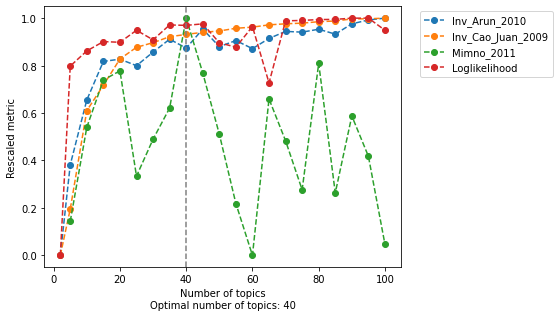

In [64]:
model=evaluate_models(models,
                     select_model=None, 
                     return_model=True, 
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save= outDir + 'models/model_selection.pdf')

In [65]:
# Add model to cisTopicObject
cistopic_obj.add_LDA_model(model)

In [66]:
# Save
with open(outDir + 'DPCL_cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

## 5. Visualize

In [1]:
# Load cisTopic object
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/'
import pickle
infile = open(outDir + 'DPCL_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [17]:
from pycisTopic.clust_vis import *
find_clusters(cistopic_obj,
                 target  = 'cell',
                 res = [0.3], 
                 prefix = 'pycisTopic_', 
                 scale = False)
run_umap(cistopic_obj,
                 target  = 'cell', scale=False)
run_tsne(cistopic_obj,
                 target  = 'cell', scale=False)

2021-12-22 11:34:48,530 cisTopic     INFO     Finding neighbours
2021-12-22 11:34:49,105 cisTopic     INFO     Running UMAP
2021-12-22 11:35:01,592 cisTopic     INFO     Running FItSNE

Symmetrizing...
Using the given initialization.
Exaggerating Ps by 12.000000
Input similarities computed (sparsity = 0.031037)!
Learning embedding...
Using FIt-SNE approximation.
Iteration 50 (50 iterations in 0.41 seconds), cost 3.035158
Iteration 100 (50 iterations in 0.41 seconds), cost 2.564805
Iteration 150 (50 iterations in 0.43 seconds), cost 2.488259
Iteration 200 (50 iterations in 0.41 seconds), cost 2.371432
Iteration 250 (50 iterations in 0.41 seconds), cost 2.313767
Unexaggerating Ps by 12.000000
Iteration 300 (50 iterations in 0.41 seconds), cost 1.748568
Iteration 350 (50 iterations in 0.41 seconds), cost 1.421559
Iteration 400 (50 iterations in 0.47 seconds), cost 1.223892
Iteration 450 (50 iterations in 0.76 seconds), cost 1.145277
Iteration 500 (50 iterations in 0.96 seconds), cost 1.07

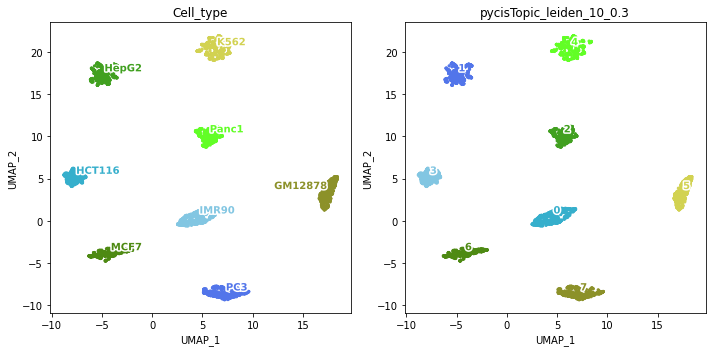

In [18]:
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['Cell_type', 'pycisTopic_leiden_10_0.3'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=5,
                 figsize=(10,5),
                 save= outDir + 'visualization/dimensionality_reduction_label.pdf')

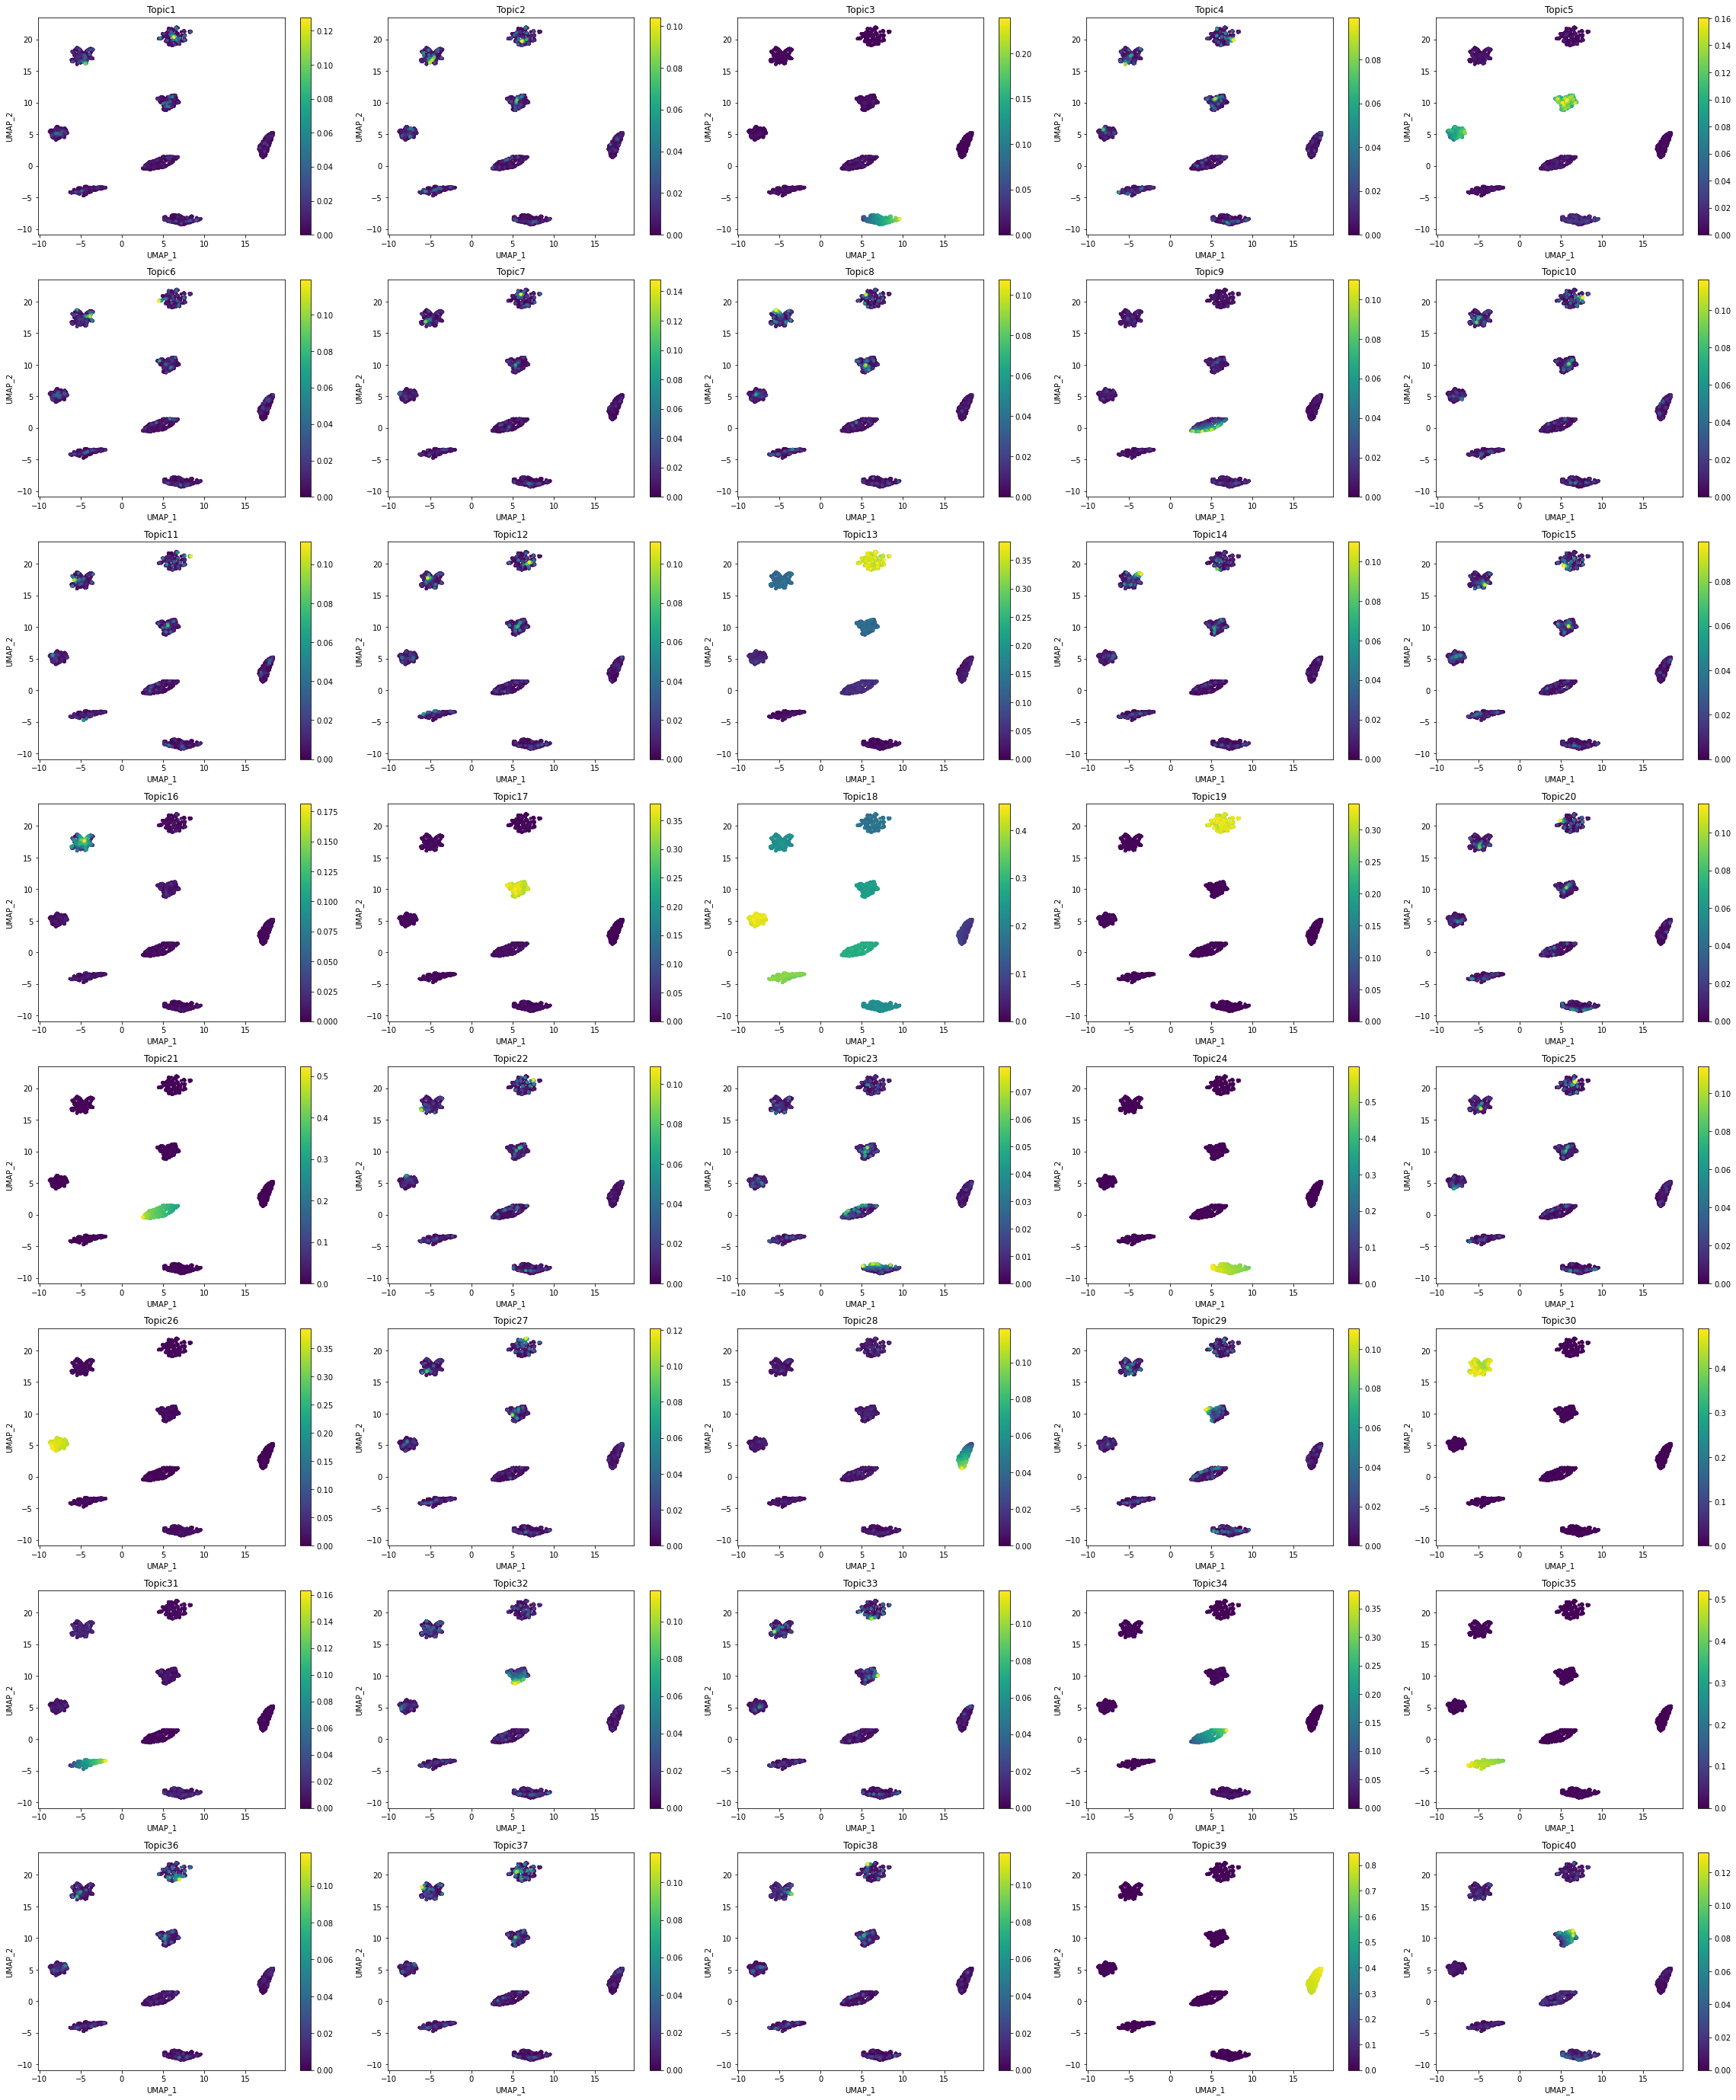

In [21]:
plot_topic(cistopic_obj,
            reduction_name = 'UMAP',
            target = 'cell',
            num_columns=5,
            save= outDir + 'visualization/dimensionality_reduction_topic_contr.pdf')

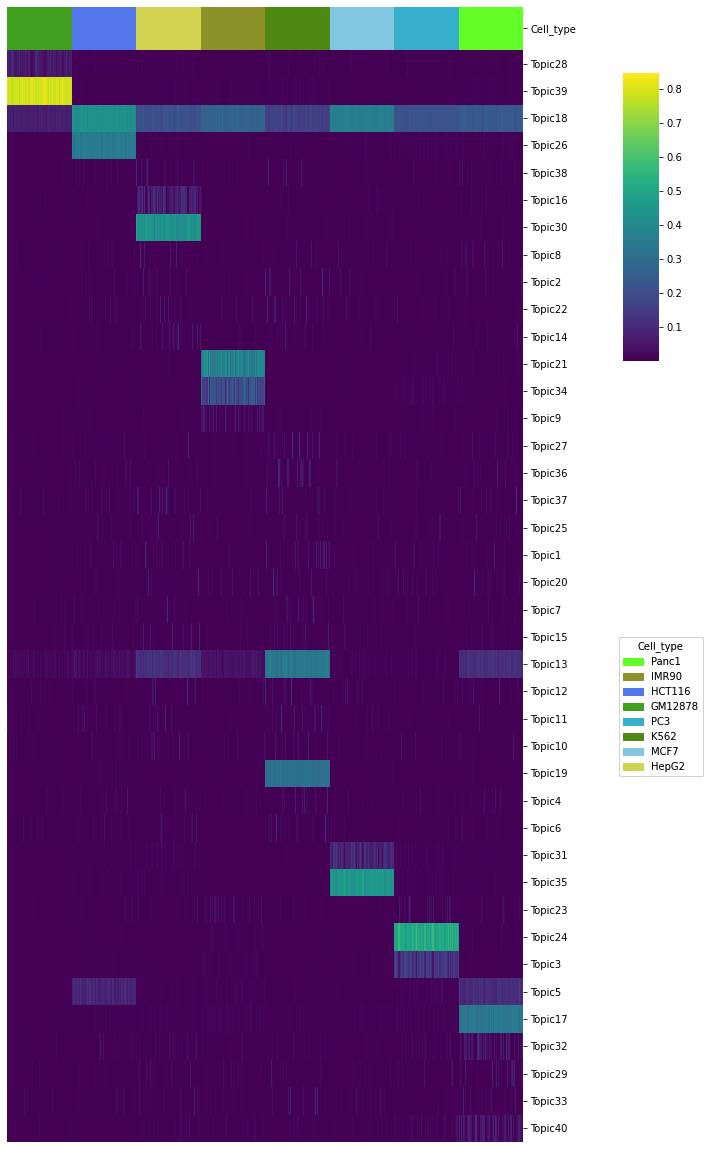

In [3]:
from pycisTopic.clust_vis import *
cell_topic_heatmap(cistopic_obj,
                     variables = ['Cell_type'],
                     scale = False,
                     legend_loc_x = 1.05,
                     legend_loc_y = -1.2,
                     legend_dist_y = -1,
                     figsize=(10,20),
                     save = outDir + 'visualization/heatmap_topic_contr.pdf')

In [ ]:
cell_line_type={'GM12878': 'B_cell', 'Panc1': 'Pancreatic_cancer', 'HepG2': 'Hepatic_cancer', 'PC3': 'Prostate_cancer', 
                'HCT116': 'Colon_cancer', 'MCF7': 'Breast_cancer', 'IMR90': 'Lung_fibroblast', 'K562': 'Leukemia'}
cistopic_obj.cell_data['Line_type'] = [cell_line_type[key] for key in cistopic_obj.cell_data['Cell_type']]

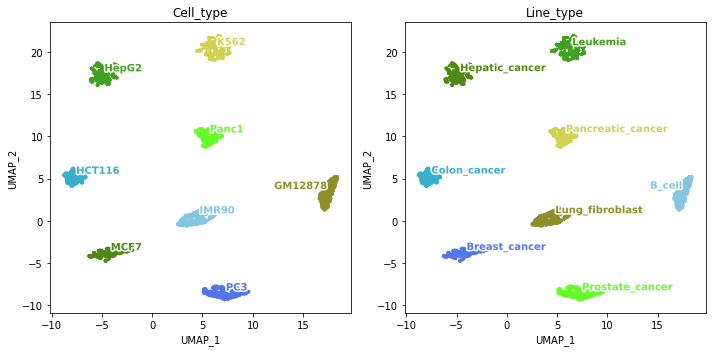

In [24]:
plot_metadata(cistopic_obj,
                 reduction_name='UMAP',
                 variables=['Cell_type', 'Line_type'], # Labels from RNA and new clusters
                 target='cell', num_columns=2,
                 text_size=10,
                 dot_size=5,
                 figsize=(10,5),
                 save= outDir + 'visualization/dimensionality_reduction_label_wtype.pdf')

In [28]:
# Save
with open(outDir + 'DPCL_cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

## 6. Topic binarization

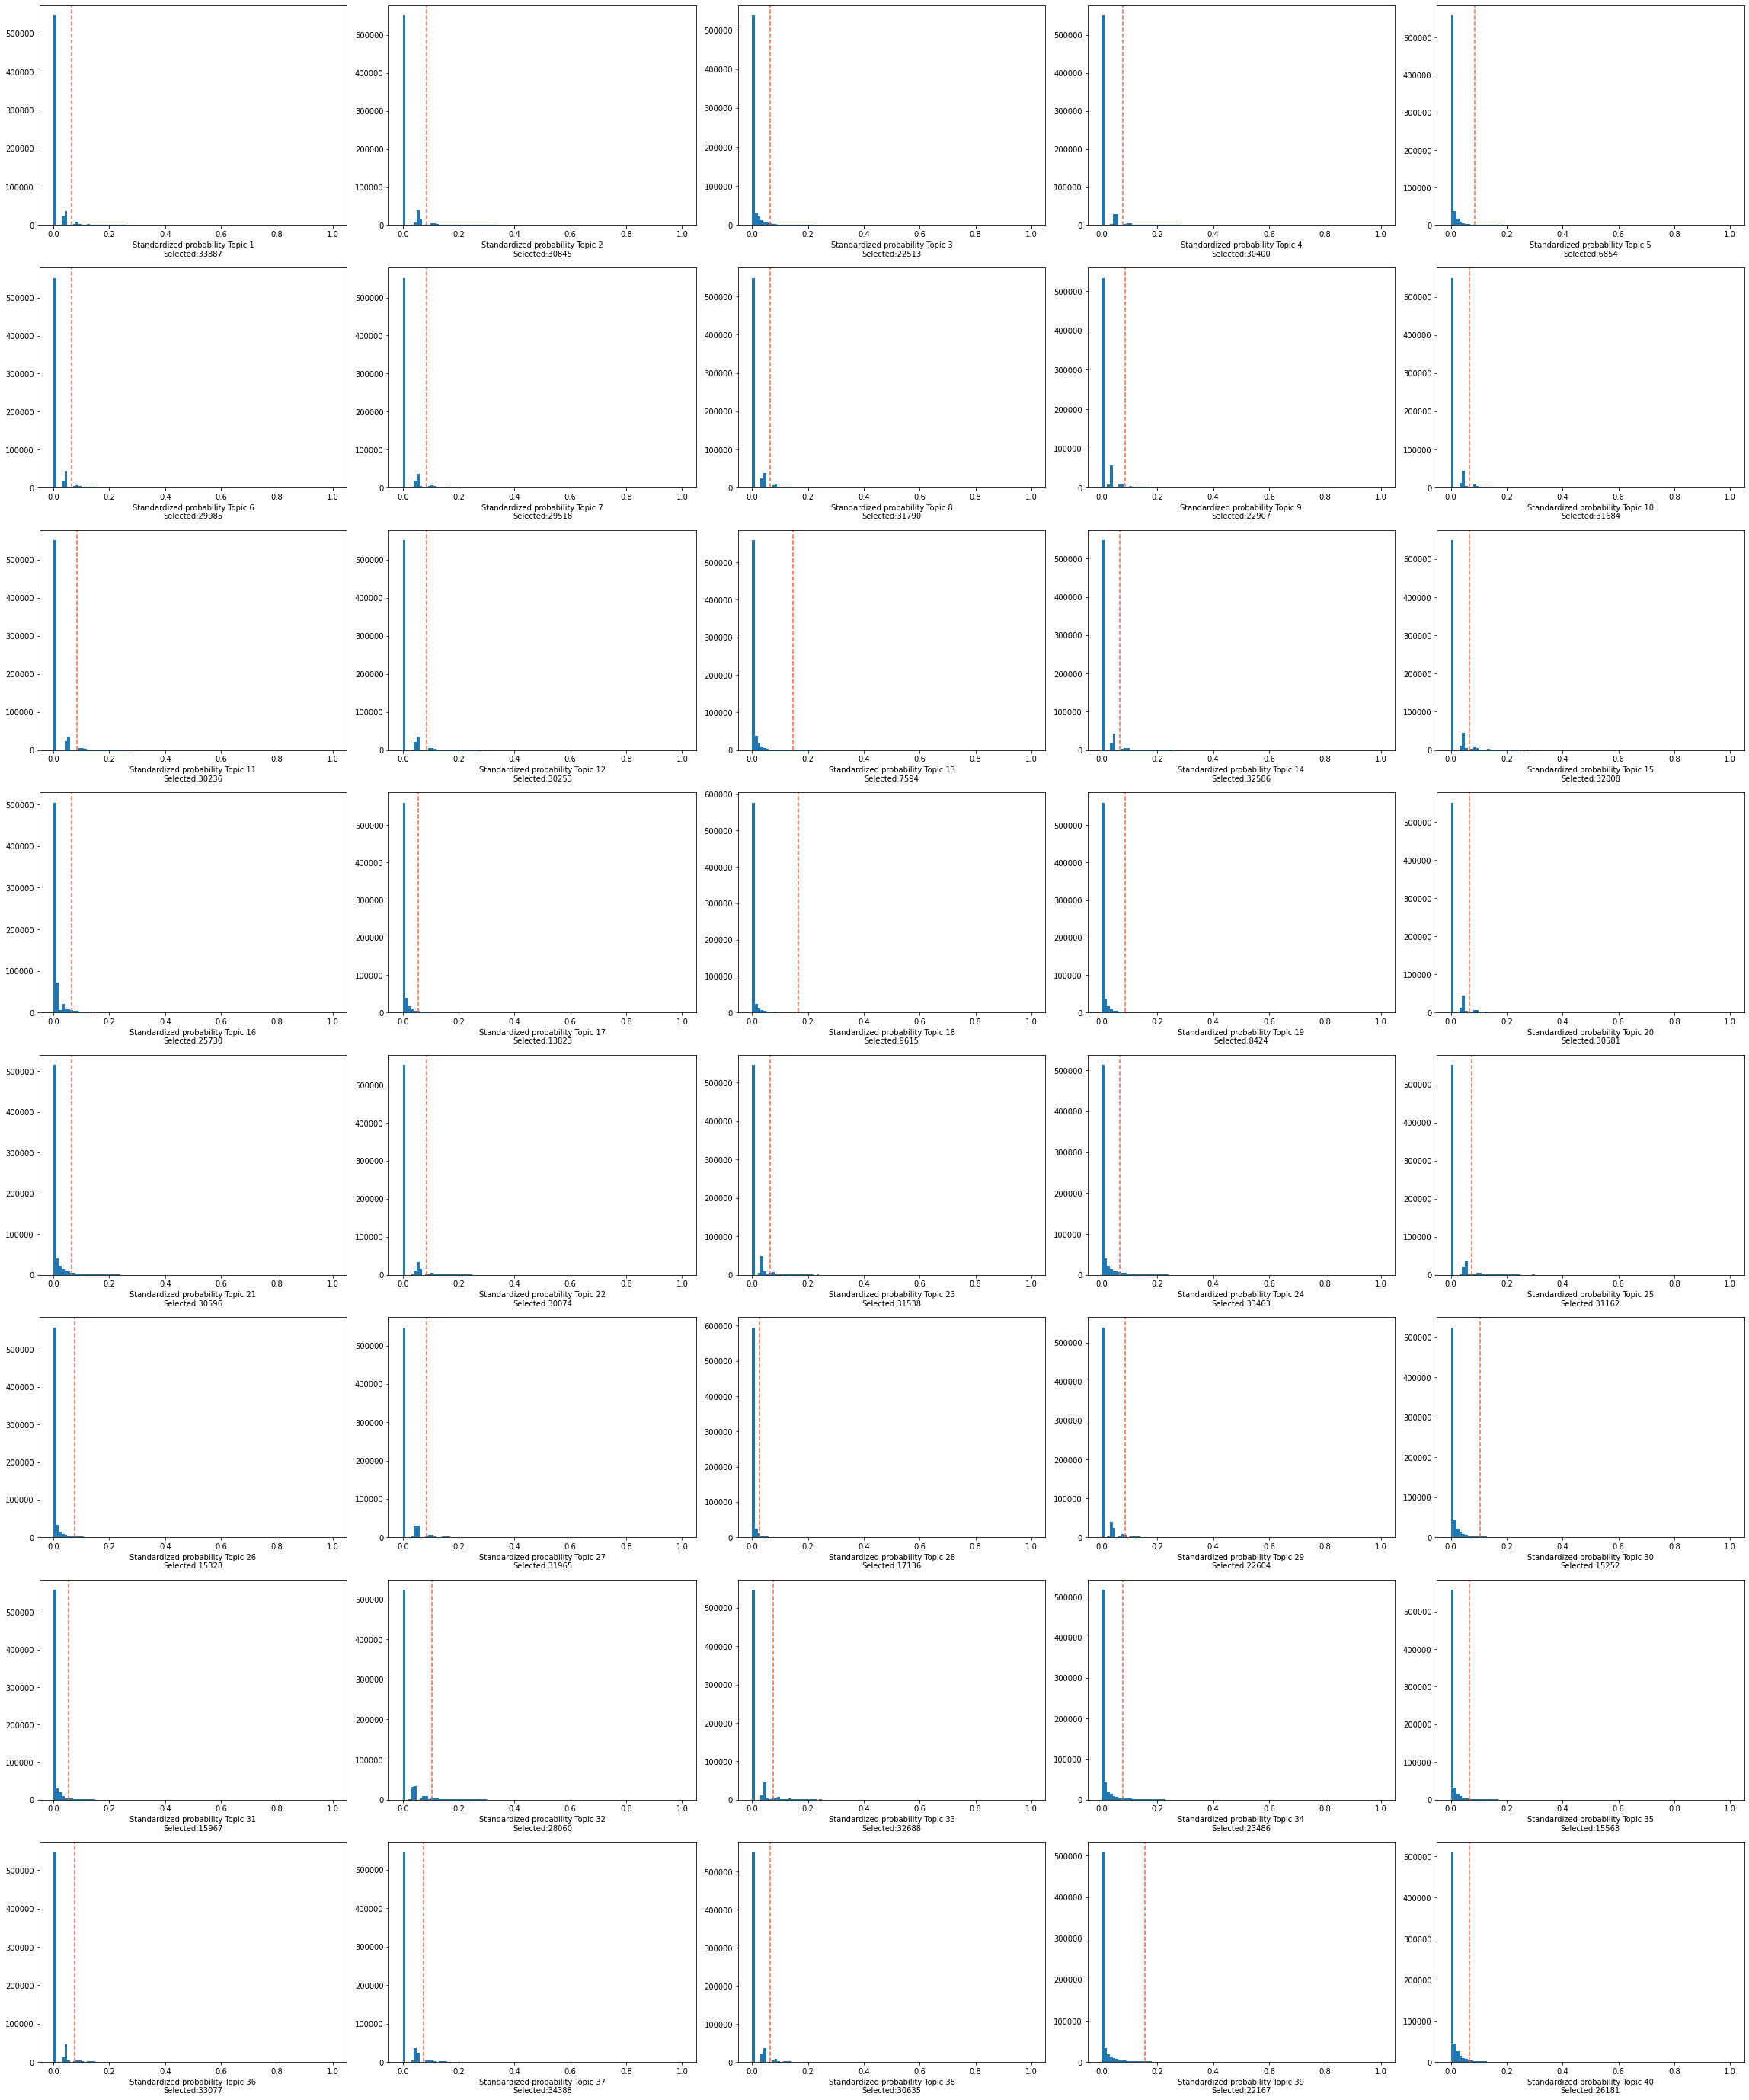

In [34]:
#from pycisTopic.topic_binarization import *
region_bin_topics = binarize_topics(cistopic_obj, 
                                    method='otsu', 
                                    plot=True, 
                                    num_columns=5, 
                                    save = outDir + 'topic_binarization/otsu')

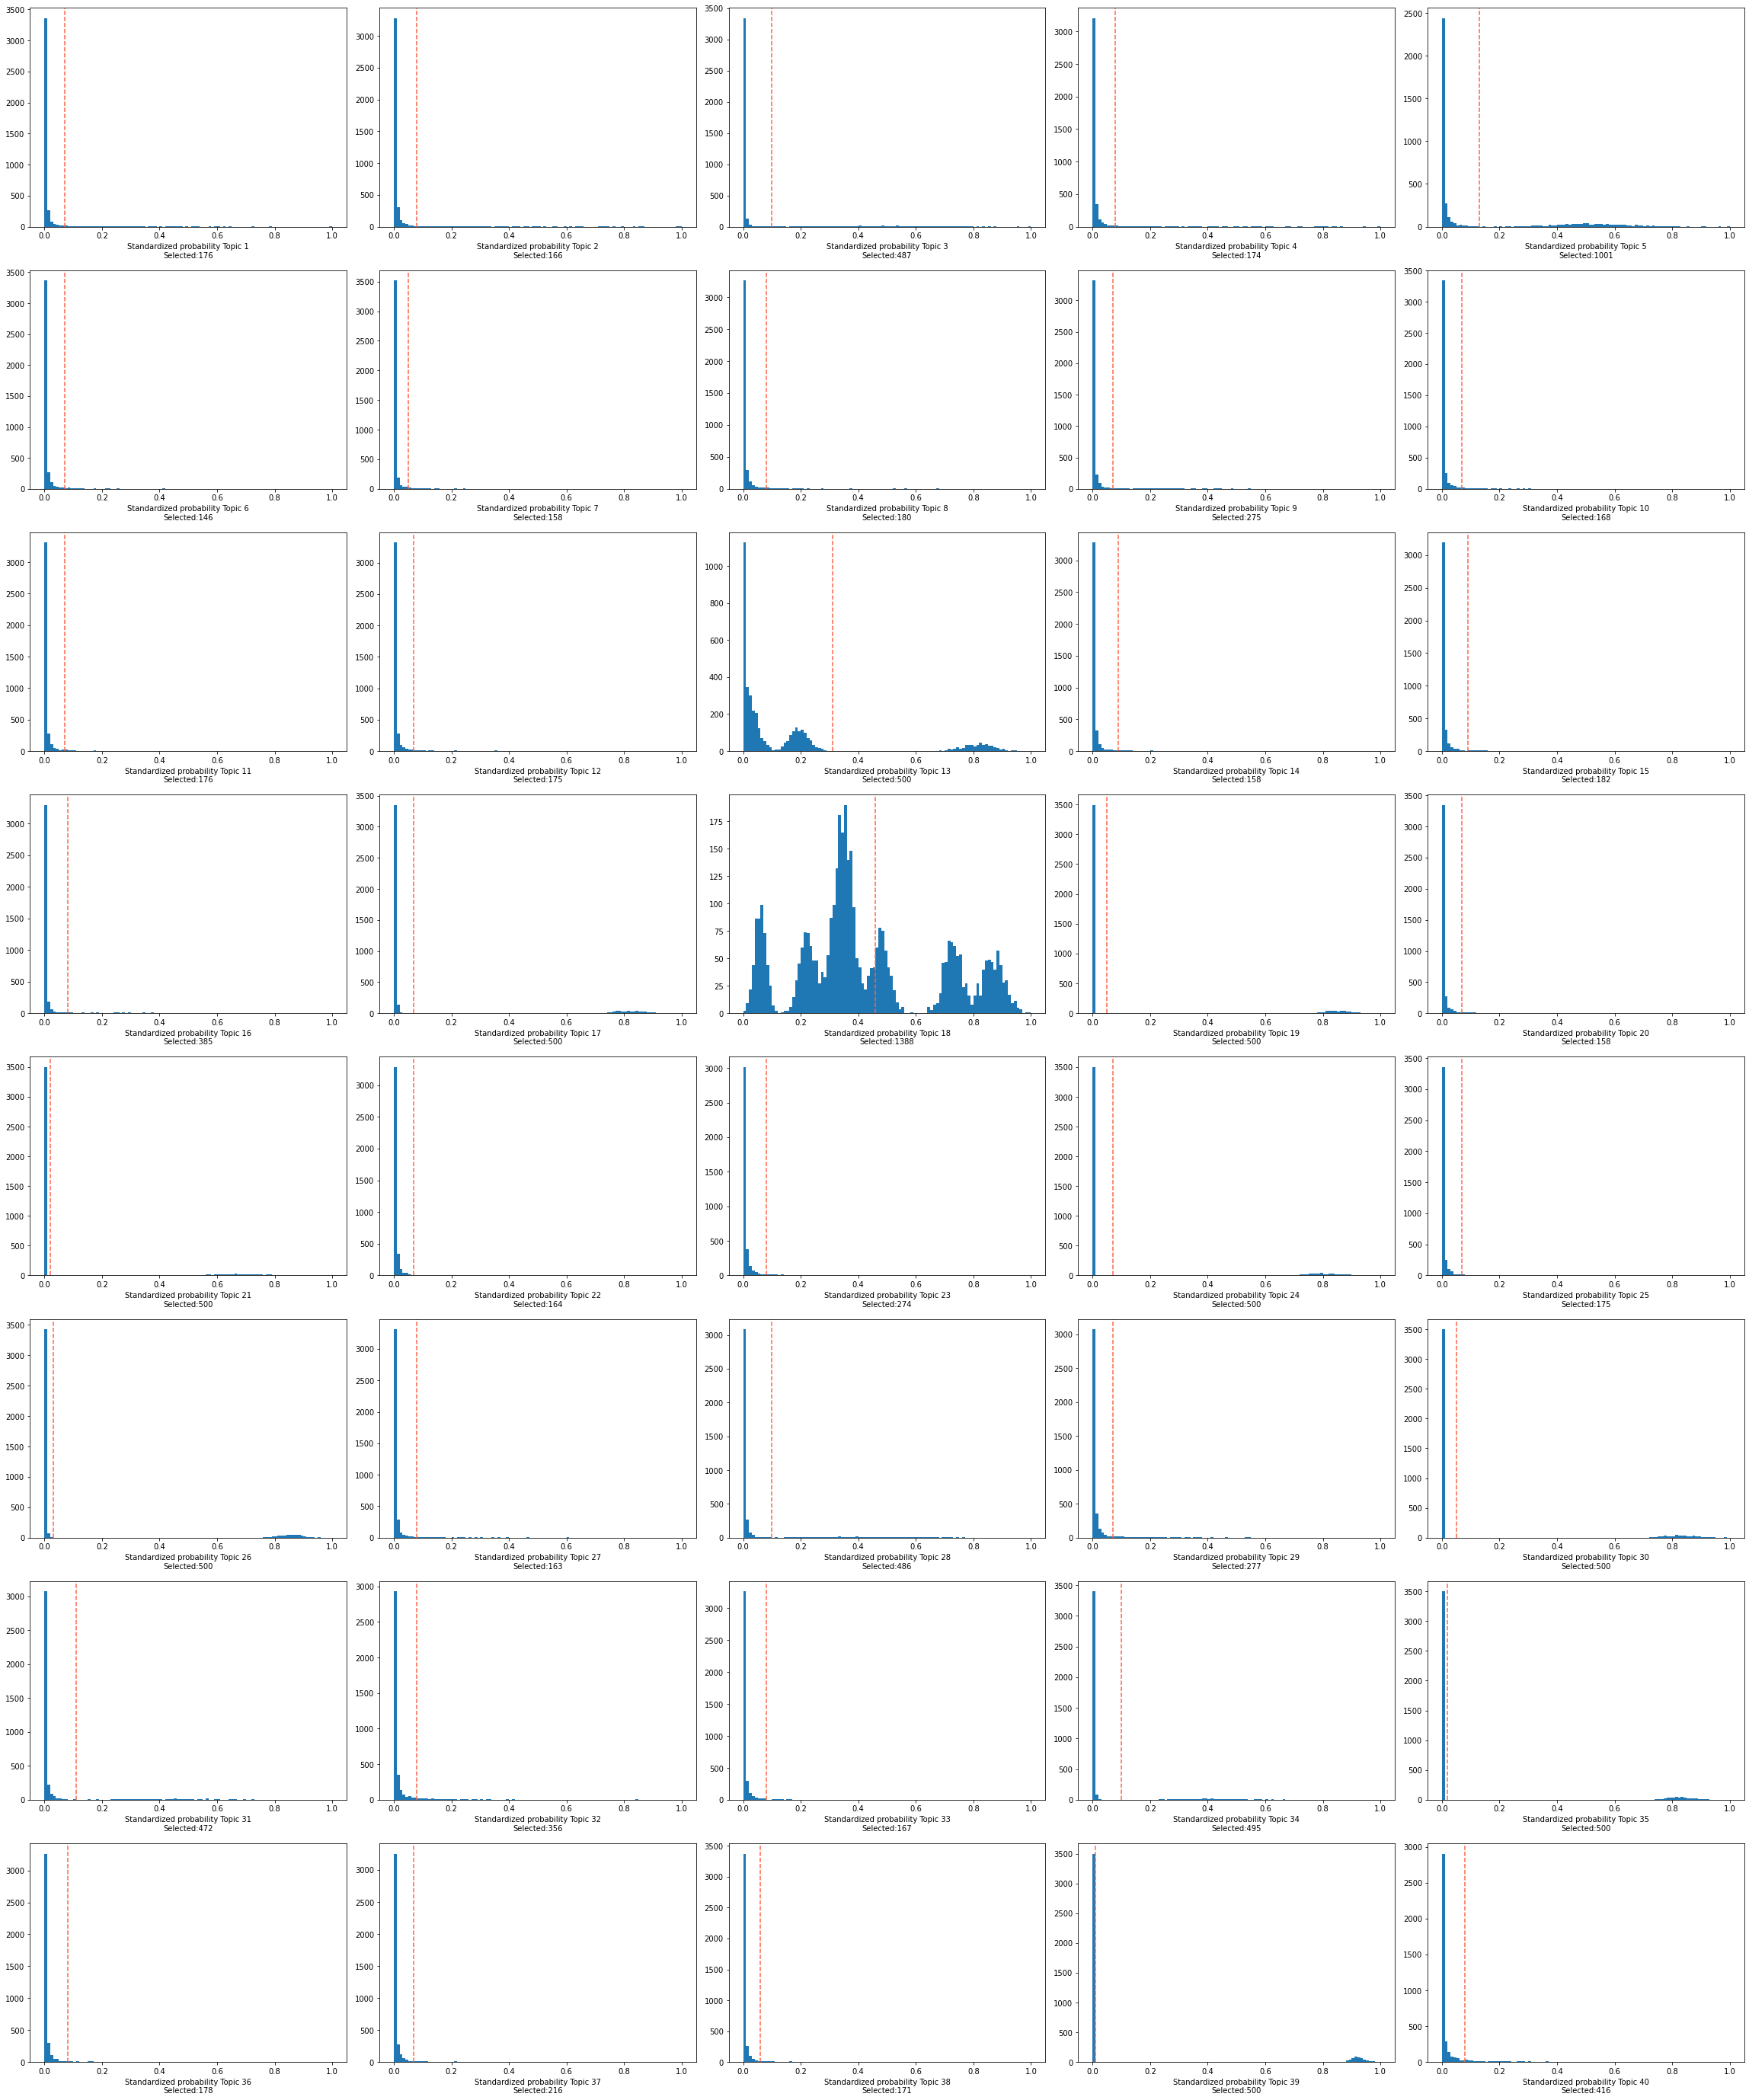

In [35]:
binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=True, num_columns=5, nbins=100)

In [36]:
from pycisTopic.topic_qc import *
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

In [37]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

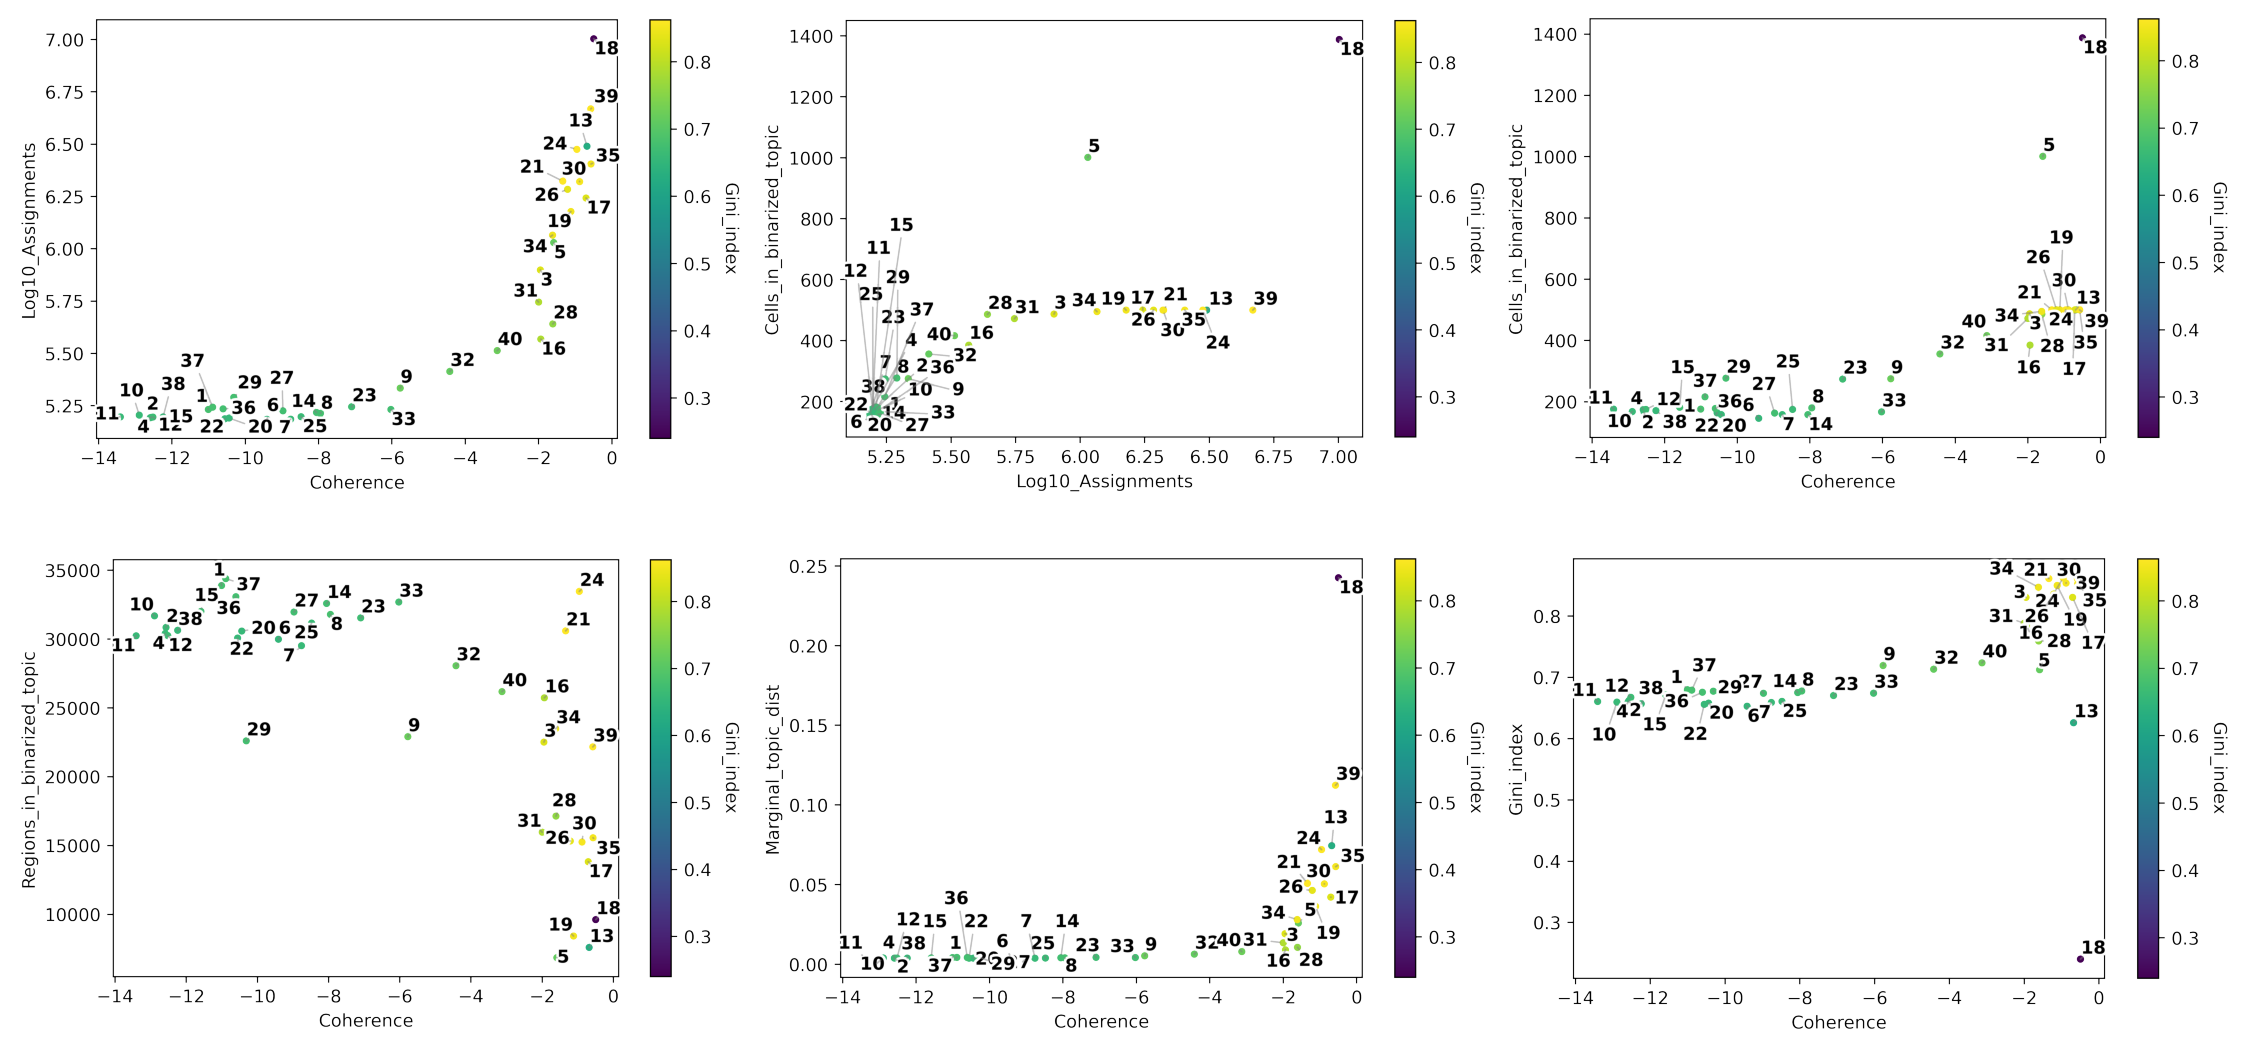

In [38]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
fig.savefig(outDir + 'topic_binarization/Topic_qc.pdf', bbox_inches='tight')
plt.show()

In [39]:
topic_annot = topic_annotation(cistopic_obj, annot_var='Cell_type', binarized_cell_topic=binarized_cell_topic, general_topic_thr = 0.2)

/opt/venv/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: divide by zero encountered in double_scalars
  zstat = value / std


In [40]:
topic_qc_metrics = pd.concat([topic_annot[['Cell_type', 'Ratio_cells_in_topic', 'Ratio_group_in_population']], topic_qc_metrics], axis=1)

In [41]:
topic_qc_metrics

,Cell_type,Ratio_cells_in_topic,Ratio_group_in_population,Log10_Assignments,Assignments,Regions_in_binarized_topic,Cells_in_binarized_topic,Coherence,Marginal_topic_dist,Gini_index
Topic1,"HepG2, K562",0.044,0.25,5.232254,170708.0,33887,176,-11.008869,0.004226,0.679899
Topic2,"HepG2, K562",0.0415,0.25,5.194240,156401.0,30845,166,-12.569665,0.003883,0.662344
Topic3,PC3,0.12175,0.125,5.898820,792173.0,22513,487,-1.949712,0.019186,0.830677
Topic4,"HepG2, K562",0.0435,0.25,5.192729,155858.0,30400,174,-12.593289,0.003870,0.660246
Topic5,"Panc1, HCT116",0.25025,0.25,6.029699,1070778.0,6854,1001,-1.586802,0.025877,0.712479
Topic6,"HepG2, K562",0.0365,0.25,5.185307,153217.0,29985,146,-9.411112,0.003806,0.652965
Topic7,"HepG2, K562",0.0395,0.25,5.185879,153419.0,29518,158,-8.762467,0.003811,0.659020
Topic8,"Panc1, HepG2, K562",0.045,0.375,5.213823,163615.0,31790,180,-7.949535,0.004056,0.677729
Topic9,IMR90,0.06875,0.125,5.334325,215936.0,22907,275,-5.773931,0.005316,0.719346
Topic10,"HepG2, K562",0.042,0.25,5.205261,160421.0,31684,168,-12.893721,0.003979,0.659686


In [42]:
# Save
with open(outDir + 'topic_binarization/Topic_qc_metrics_annot.pkl', 'wb') as f:
  pickle.dump(topic_qc_metrics, f)
with open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'wb') as f:
  pickle.dump(binarized_cell_topic, f)
with open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'wb') as f:
  pickle.dump(region_bin_topics, f)

## 7. Differentially accessible regions (DARs)

In [4]:
# Load cisTopic object
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/'
import pickle
infile = open(outDir + 'DPCL_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [5]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)

2022-01-21 15:13:39,179 cisTopic     INFO     Imputing drop-outs
2022-01-21 15:13:45,415 cisTopic     INFO     Scaling
2022-01-21 15:13:53,016 cisTopic     INFO     Keep non zero rows
2022-01-21 15:14:02,751 cisTopic     INFO     Imputed accessibility sparsity: 0.7112005460833544
2022-01-21 15:14:02,753 cisTopic     INFO     Create CistopicImputedFeatures object
2022-01-21 15:14:02,754 cisTopic     INFO     Making matrix sparse
2022-01-21 15:14:41,231 cisTopic     INFO     Done!


In [45]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2021-12-22 12:38:38,650 cisTopic     INFO     Normalizing imputed data
2021-12-22 12:39:04,644 cisTopic     INFO     Done!


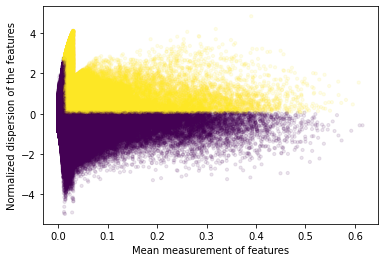

2021-12-22 12:41:22,915 cisTopic     INFO     Done!


In [47]:
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125, 
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20, 
                                           n_top_features=None,
                                           plot=True,
                                           save= outDir + 'DARs/HVR_plot.pdf')

In [49]:
markers_dict= find_diff_features(cistopic_obj, 
                      imputed_acc_obj,
                      variable='Cell_type',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=1) 

2021-12-22 12:42:56,190 cisTopic     INFO     Formatting data for GM12878
2021-12-22 12:42:58,290 cisTopic     INFO     Computing p-value for GM12878
2021-12-22 12:43:24,430 cisTopic     INFO     Computing log2FC for GM12878
2021-12-22 12:43:26,867 cisTopic     INFO     GM12878 done!
2021-12-22 12:43:26,883 cisTopic     INFO     Formatting data for HCT116
2021-12-22 12:43:29,229 cisTopic     INFO     Computing p-value for HCT116
2021-12-22 12:43:54,976 cisTopic     INFO     Computing log2FC for HCT116
2021-12-22 12:43:57,750 cisTopic     INFO     HCT116 done!
2021-12-22 12:43:57,766 cisTopic     INFO     Formatting data for HepG2
2021-12-22 12:44:00,038 cisTopic     INFO     Computing p-value for HepG2
2021-12-22 12:44:25,263 cisTopic     INFO     Computing log2FC for HepG2
2021-12-22 12:44:28,314 cisTopic     INFO     HepG2 done!
2021-12-22 12:44:28,334 cisTopic     INFO     Formatting data for IMR90
2021-12-22 12:44:30,731 cisTopic     INFO     Computing p-value for IMR90
2021-12-22 

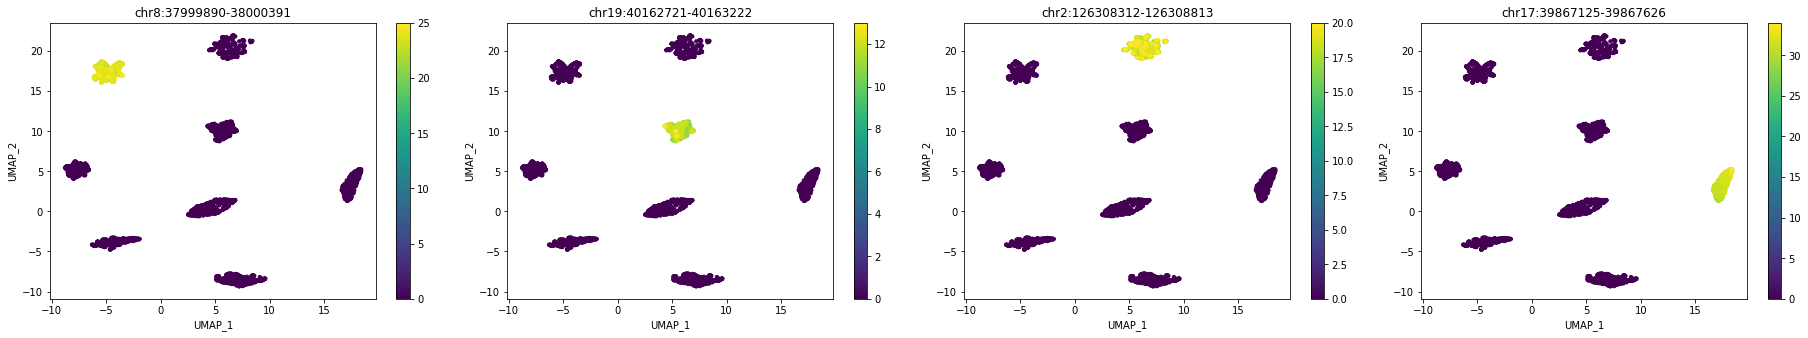

In [50]:
from pycisTopic.clust_vis import *
plot_imputed_features(cistopic_obj,
                    reduction_name='UMAP',
                    imputed_data=imputed_acc_obj,
                    features=[markers_dict[x].index.tolist()[0] for x in ['HepG2', 'Panc1', 'K562', 'GM12878']],
                    scale=False,
                    num_columns=4,
                    selected_cells = cistopic_obj.projections['cell']['UMAP'].index.tolist(),
                    save= outDir + 'DARs/example_best_DARs.pdf')

In [51]:
x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

GM12878: 20745
HCT116: 18065
HepG2: 18032
IMR90: 22200
K562: 14049
MCF7: 20928
PC3: 28878
Panc1: 17138


In [52]:
# Save
with open(outDir + 'DARs/Imputed_accessibility.pkl', 'wb') as f:
  pickle.dump(imputed_acc_obj, f)
with open(outDir + 'DARs/DARs.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)

In [3]:
# Export DARs to tsv
for x in DARs_dict.keys():
    DARs_dict[x].to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/DARs/tsv/'+x+'.tsv', sep='\t')

In [7]:
# Repeat for all region values
markers_dict= find_diff_features(cistopic_obj, 
                      imputed_acc_obj,
                      variable='Cell_type',
                      var_features=None,
                      contrasts=None,
                      adjpval_thr=1.01,
                      log2fc_thr=-100000000,
                      n_cpu=1) 

2022-01-21 15:15:13,063 cisTopic     INFO     Formatting data for GM12878
2022-01-21 15:15:22,000 cisTopic     INFO     Computing p-value for GM12878
2022-01-21 15:19:07,070 cisTopic     INFO     Computing log2FC for GM12878
2022-01-21 15:19:36,992 cisTopic     INFO     GM12878 done!
2022-01-21 15:19:37,093 cisTopic     INFO     Formatting data for HCT116
2022-01-21 15:19:49,505 cisTopic     INFO     Computing p-value for HCT116
2022-01-21 15:23:43,804 cisTopic     INFO     Computing log2FC for HCT116
2022-01-21 15:24:02,447 cisTopic     INFO     HCT116 done!
2022-01-21 15:24:02,534 cisTopic     INFO     Formatting data for HepG2
2022-01-21 15:24:12,355 cisTopic     INFO     Computing p-value for HepG2
2022-01-21 15:27:51,653 cisTopic     INFO     Computing log2FC for HepG2
2022-01-21 15:28:11,763 cisTopic     INFO     HepG2 done!
2022-01-21 15:28:11,853 cisTopic     INFO     Formatting data for IMR90
2022-01-21 15:28:21,591 cisTopic     INFO     Computing p-value for IMR90
2022-01-21 

In [13]:
markers_dict['GM12878'][markers_dict['GM12878']['Log2FC']<0.1]

,Log2FC,Adjusted_pval,Contrast
chr20:41317471-41317972,0.099959,0.0,GM12878
chr2:28274805-28275306,0.099889,0.023907,GM12878
chr2:55048931-55049432,0.099874,0.0,GM12878
chr12:94101381-94101882,0.099832,0.0,GM12878
chr2:85921612-85922113,0.099653,0.0,GM12878
...,...,...,...
chr1:202056904-202057405,-43.774555,0.0,GM12878
chr12:6383839-6384340,-43.859707,0.0,GM12878
chr6:35318214-35318715,-43.947274,0.0,GM12878
chr1:201275163-201275664,-43.954571,0.0,GM12878


In [11]:
# Export DARs to tsv
for x in markers_dict.keys():
    markers_dict[x].to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/DARs/all_tsv/'+x+'.tsv', sep='\t')

In [14]:
# Export DARs to tsv
cistopic_obj.selected_model.topic_region.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/Topic_region.tsv', sep='\t')

## 8. DAGS

In [2]:
# Load cisTopic object
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/'
import pickle
infile = open(outDir + 'DPCL_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb')
imputed_acc_obj = pickle.load(infile)
infile.close()
# Load DARs
import pickle
infile = open(outDir + 'DARs/DARs.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()

In [3]:
# Get TSS annotations
import pybiomart as pbm
import pyranges as pr
# For mouse
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For human
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For fly
#dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'strand', 'external_gene_name', 'transcription_start_site', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = 'chr' + annot['Chromosome/scaffold name'].astype(str)
annot.columns=['Chromosome', 'Start', 'End', 'Strand', 'Gene','Transcription_Start_Site', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
annot.Strand[annot.Strand == 1] = '+'
annot.Strand[annot.Strand == -1] = '-'
pr_annotation = pr.PyRanges(annot.dropna(axis = 0))

/local_scratch/tmp-vsc31305/ipykernel_23033/2487299827.py:10: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'strand', 'external_gene_name', 'transcription_start_site', 'transcript_biotype'])


In [4]:
# Get chromosome sizes
import pandas as pd
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
chromsizes=pr.PyRanges(chromsizes)

In [5]:
from pycisTopic.gene_activity import *
gene_act, weigths = get_gene_activity(imputed_acc_obj, # Region-cell probabilities
                pr_annotation, # Gene annotation
                chromsizes, # Chromosome size
                use_gene_boundaries=True, # Whether to use the whole search space or stop when encountering another gene
                upstream=[1000, 100000], # Search space upstream. The minimum means that even if there is a gene right next to it 
                                      #these bp will be taken (1kbp here)
                downstream=[1000,100000], # Search space downstream
                distance_weight=True, # Whether to add a distance weight (an exponential function, the weight will decrease with distance)
                decay_rate=1, # Exponent for the distance exponential funciton (the higher the faster will be the decrease)
                extend_gene_body_upstream=10000, # Number of bp upstream immune to the distance weight (their value will be maximum for 
                                      #this weight)
                extend_gene_body_downstream=500, # Number of bp downstream immune to the distance weight
                gene_size_weight=False, # Whether to add a weights based on the length of the gene
                gene_size_scale_factor='median', # Dividend to calculate the gene size weigth. Default is the median value of all genes
                                      #in the genome
                remove_promoters=False, # Whether to remove promoters when computing gene activity scores
                average_scores=True, # Whether to divide by the total number of region assigned to a gene when calculating the gene 
                                      #activity score
                scale_factor=1, # Value to multiply for the final gene activity matrix
                extend_tss=[10,10], # Space to consider a promoter
                gini_weight = True, # Whether to add a gini index weigth. The more unique the region is, the higher this weight will be
                return_weights= True, # Whether to return the final weights
                project='Gene_activity') # Project name for the gene activity object

2021-12-22 13:44:47,951 cisTopic     INFO     Calculating gene boundaries


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2021-12-22 13:44:58,642 cisTopic     INFO     Calculating distances
2021-12-22 13:46:43,204 cisTopic     INFO     Calculating distance weigths
2021-12-22 13:46:45,270 cisTopic     INFO     Distance weights done
2021-12-22 13:46:45,272 cisTopic     INFO     Calculating gini weights
2021-12-22 13:47:49,631 cisTopic     INFO     Getting gene activity scores
2021-12-22 14:02:14,654 cisTopic     INFO     Creating imputed features object


In [6]:
markers_dict= find_diff_features(cistopic_obj, 
                      gene_act,
                      variable='Cell_type',
                      var_features=None,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=1) 

2021-12-22 14:02:29,385 cisTopic     INFO     Formatting data for GM12878
2021-12-22 14:02:30,198 cisTopic     INFO     Computing p-value for GM12878
2021-12-22 14:02:38,372 cisTopic     INFO     Computing log2FC for GM12878
2021-12-22 14:02:38,912 cisTopic     INFO     GM12878 done!
2021-12-22 14:02:38,917 cisTopic     INFO     Formatting data for HCT116
2021-12-22 14:02:39,731 cisTopic     INFO     Computing p-value for HCT116
2021-12-22 14:02:47,996 cisTopic     INFO     Computing log2FC for HCT116
2021-12-22 14:02:48,519 cisTopic     INFO     HCT116 done!
2021-12-22 14:02:48,524 cisTopic     INFO     Formatting data for HepG2
2021-12-22 14:02:49,336 cisTopic     INFO     Computing p-value for HepG2
2021-12-22 14:02:57,661 cisTopic     INFO     Computing log2FC for HepG2
2021-12-22 14:02:58,188 cisTopic     INFO     HepG2 done!
2021-12-22 14:02:58,194 cisTopic     INFO     Formatting data for IMR90
2021-12-22 14:02:59,005 cisTopic     INFO     Computing p-value for IMR90
2021-12-22 

In [8]:
# Save
with open(outDir + 'DAGs/Gene_activity.pkl', 'wb') as f:
  pickle.dump(gene_act, f)
with open(outDir + 'DAGs/DAGs.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)

## 9. Export to loom

In [1]:
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/pycisTopic/'
# Load cisTopic object
import pickle
infile = open(outDir + 'DPCL_cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
imputed_acc_obj = pickle.load(infile)
infile.close()
# Load region binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
binarized_topic_region = pickle.load(infile)
infile.close()
# Load cell binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
binarized_cell_topic = pickle.load(infile)
infile.close()
# Load DARs
import pickle
infile = open(outDir + 'DARs/DARs.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()

In [2]:
# Format coordinate system
from loomxpy.loomxpy import SCopeLoom
path_to_annotated_rna_loom = "/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/vsn/grnboost/out/data/scRNA_count_matrix.SINGLE_SAMPLE_SCENIC.loom"
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
grnboost_embeddings = {'GRNBoost - ' + key: loom.embeddings[key].get_embedding() for key in loom.embeddings.keys()}
path_to_annotated_rna_loom = "/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/vsn/genie3/out/data/scRNA_count_matrix.SINGLE_SAMPLE_SCENIC.loom"
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
genie3_embeddings = {'GENIE3 - ' + key: loom.embeddings[key].get_embedding() for key in loom.embeddings.keys()}
# Function
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z
# Combine
rna_embeddings = merge_two_dicts(grnboost_embeddings, genie3_embeddings)

In [3]:
for key in rna_embeddings.keys():
    rna_embeddings[key].index = rna_embeddings[key].index + '___DPLC'
    rna_embeddings[key] = rna_embeddings[key].loc[cistopic_obj.cell_names]

,_X,_Y
K562_33___DPLC,2.098409,-7.357330
K562_69___DPLC,1.340508,-6.916246
K562_206___DPLC,1.306690,-7.580635
Panc1_80___DPLC,-10.286281,2.957377
MCF7_89___DPLC,10.088906,-8.647559
...,...,...
MCF7_496___DPLC,9.946555,-7.151568
HepG2_238___DPLC,-7.560800,-7.524248
HepG2_226___DPLC,-8.332444,-7.430928
HepG2_450___DPLC,-9.542184,-7.800214


In [5]:
cistopic_obj.projections['cell'] = merge_two_dicts(cistopic_obj.projections['cell'], rna_embeddings)
cistopic_obj.projections['cell']['pycisTopic - UMAP'] = cistopic_obj.projections['cell'].pop('UMAP')
cistopic_obj.projections['cell']['pycisTopic - tSNE'] = cistopic_obj.projections['cell'].pop('tSNE')
cistopic_obj.projections['cell'].keys()

dict_keys(['GRNBoost - HVG UMAP', 'GRNBoost - HVG t-SNE', 'GRNBoost - HVG PC1/PC2', 'GRNBoost - SCENIC AUC UMAP', 'GRNBoost - SCENIC AUC t-SNE', 'GENIE3 - HVG UMAP', 'GENIE3 - HVG t-SNE', 'GENIE3 - HVG PC1/PC2', 'GENIE3 - SCENIC AUC UMAP', 'GENIE3 - SCENIC AUC t-SNE', 'pycisTopic - UMAP', 'pycisTopic - tSNE'])

In [22]:
# Prepare DARs dict
cluster_markers = {'Cell_type': DARs_dict}
# Export to loom
from pycisTopic.loom import *
export_region_accessibility_to_loom(accessibility_matrix = imputed_acc_obj,
                  cistopic_obj = cistopic_obj, 
                  binarized_topic_region = binarized_topic_region,
                  binarized_cell_topic = binarized_cell_topic,
                  out_fname = outDir + 'loom/DPCL_pycisTopic_region_accessibility.loom',
                  cluster_annotation = ['Cell_type'],
                  cluster_markers = cluster_markers,
                  tree_structure = ('DPCL', 'pycisTopic'),
                  title = 'Region accessibility all',
                  nomenclature = "hg38",
                  split_pattern = '-')   

2022-01-10 18:44:50,289 cisTopic     INFO     Creating minimal loom
2022-01-10 18:48:11,709 cisTopic     INFO     Adding annotations
2022-01-10 18:49:08,129 cisTopic     INFO     Adding clusterings
2022-01-10 18:49:08,170 cisTopic     INFO     Adding markers
2022-01-10 18:49:17,785 cisTopic     INFO     Exporting


In [20]:
# Get DGEM
path_to_annotated_rna_loom = "/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/vsn/grnboost/out/data/scRNA_count_matrix.SINGLE_SAMPLE_SCENIC.loom"
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
dgem = loom.ex_mtx
dgem.index = dgem.index + '___DPLC'
# Get regulons
regulons = get_regulons(loom)
# Create loom
export_gene_activity_to_loom(gene_activity_matrix = dgem,
                  cistopic_obj = cistopic_obj, 
                  regulons = regulons,
                  out_fname = outDir + 'loom/DPCL_gene_expression_grnboost.loom',
                  cluster_annotation = ['Cell_type'],
                  cluster_markers = None,
                  tree_structure = ('DPCL', 'pycisTopic'),
                  title = 'Gene expression all',
                  nomenclature = "hg38",
                  split_pattern = '-',
                  num_workers = 8)  

2022-01-10 18:35:37,070 cisTopic     INFO     Creating minimal loom
2022-01-10 18:37:28,395 cisTopic     INFO     Adding annotations
2022-01-10 18:37:31,110 cisTopic     INFO     Adding clusterings
2022-01-10 18:37:31,144 cisTopic     INFO     Exporting


/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:459: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")
/opt/venv/lib/python3.8/site-packages/loomxpy/loomxpy.py:437: FutureWarning: The default value of regex will change from True to False in a future version.
  regulons.columns = regulons.columns.str.replace("_?\\(", "_(")


In [21]:
# Get DGEM
path_to_annotated_rna_loom = "/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/vsn/genie3/out/data/scRNA_count_matrix.SINGLE_SAMPLE_SCENIC.loom"
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
dgem = loom.ex_mtx
# Get regulons
regulons = get_regulons(loom)
dgem.index = dgem.index + '___DPLC'
# Create loom
export_gene_activity_to_loom(gene_activity_matrix = dgem,
                  cistopic_obj = cistopic_obj, 
                  regulons = regulons,
                  out_fname = outDir + 'loom/DPCL_gene_expression_genie3.loom',
                  cluster_annotation = ['Cell_type'],
                  cluster_markers = None,
                  tree_structure = ('DPCL', 'pycisTopic'),
                  title = 'Gene expression all',
                  nomenclature = "hg38",
                  split_pattern = '-',
                  num_workers = 8 )  

2022-01-10 18:39:08,015 cisTopic     INFO     Creating minimal loom
2022-01-10 18:40:20,869 cisTopic     INFO     Adding annotations
2022-01-10 18:40:23,989 cisTopic     INFO     Adding clusterings
2022-01-10 18:40:24,022 cisTopic     INFO     Exporting


### 10. Generate bigwigs

In [17]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='https://www.encodeproject.org/files/GRCh38_EBV.chrom.sizes/@@download/GRCh38_EBV.chrom.sizes.tsv'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
#chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
#chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [19]:
from pycisTopic.pseudobulk_peak_calling import *
fragments_dict = {'DPLC': '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/atac_fragments/fragments.tsv'}
bw_paths, bed_paths = export_pseudobulk(input_data = cistopic_obj.cell_data,
                 variable = 'Cell_type',
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = outDir + 'consensus_peak_calling/pseudobulk_bed_files/',
                 bigwig_path = outDir + 'consensus_peak_calling/pseudobulk_bw_files/',
                 path_to_fragments = fragments_dict,
                 n_cpu = 1,
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = '/scratch/leuven/313/vsc31305/ray_spill',
                 split_pattern = '-')

2022-01-24 15:23:23,590 cisTopic     INFO     Reading fragments from /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/DPCL/data/atac_fragments/fragments.tsv
2022-01-24 15:24:15,526 cisTopic     INFO     Creating pseudobulk for GM12878
2022-01-24 15:25:32,286 cisTopic     INFO     GM12878 done!
2022-01-24 15:25:32,290 cisTopic     INFO     Creating pseudobulk for HCT116
2022-01-24 15:26:50,376 cisTopic     INFO     HCT116 done!
2022-01-24 15:26:50,382 cisTopic     INFO     Creating pseudobulk for HepG2
2022-01-24 15:28:10,936 cisTopic     INFO     HepG2 done!
2022-01-24 15:28:10,949 cisTopic     INFO     Creating pseudobulk for IMR90
2022-01-24 15:29:31,677 cisTopic     INFO     IMR90 done!
2022-01-24 15:29:31,683 cisTopic     INFO     Creating pseudobulk for K562
2022-01-24 15:30:51,859 cisTopic     INFO     K562 done!
2022-01-24 15:30:51,864 cisTopic     INFO     Creating pseudobulk for MCF7
2022-01-24 15:32:09,855 cisTopic     INFO     MCF7 done!
2022-01-24 15:32:09,